# [실습1] 모델 학습을 위한 데이터 전처리

## 학습 목표

1. 이미지 데이터 전처리에 필요한 각종 라이브러리의 사용법을 익힙니다.

2. 이미지 데이터를 모델에 싣기 위한 전반적인 과정을 학습합니다.

3. Pytorch 모델 학습을 위해 Dataset을 생성하고, 이를 저장합니다.

# Wafer 이미지 분류를 위한 데이터 전처리

이번 시간에는 [웨이퍼(Wafer) 이미지 데이터](https://www.kaggle.com/datasets/alexandremoritz/simulated-analog-wafer-pattern-recognition)를 바탕으로 전처리 과정을 연습해보겠습니다. 

웨이퍼(Wafer)는 반도체 소자나 통합회로(IC)를 제조하는 데 사용되는 얇고 둥근 반도체 판입니다.  

웨이퍼는 순도가 매우 높은 단결정 실리콘 잉곳에서 얇게 절단하여 만들어집니다.  

이 웨이퍼 위에 여러 공정(예: 산화, 증착, 레이저 조사, 이온 주입 등)을 거쳐서 통합회로나 반도체 소자가 형성됩니다.

웨이퍼 검사는 제조 공정 중에 발생할 수 있는 결함을 찾아내는 중요한 단계입니다.  

결함이 있는 웨이퍼는 제품의 품질을 떨어뜨릴 수 있기 때문에, 공정 초기에 결함을 찾아내는 것은 비용 절감 및 품질 향상에 도움이 되겠지요.  

실습에 사용되는 데이터의 결함은 다양한 전기적 테스트(저항, 전압 등)을 바탕으로 측정되었습니다.

환경 확인

In [2]:
!nvidia-smi

Mon May 20 06:13:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                   On |
| N/A   31C    P0              43W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

## 1. 라이브러리 불러오기

실습에 필요한 라이브러리를 불러오겠습니다.

- `os`: 파일이나 디렉터리를 다루기 위한 라이브러리로, 모델 학습 중에 체크포인트를 저장하거나 로드하기 위해 사용될 수 있습니다.

- `numpy`, `pandas`: 데이터를 효과적으로 처리하고 분석하기 위해 사용됩니다. 주로 데이터 전처리나 분석 단계에서 활용됩니다.

- `tqdm`: 모델 학습 시 에폭이나 배치 처리의 진행 상황을 알려주어 사용자에게 학습의 진행도를 보여줍니다.

- `matplotlib`: 데이터나 학습 결과를 시각적으로 표현할 때 사용합니다.

- `torch`, `torchvision`: PyTorch 프레임워크와 관련된 라이브러리로, 딥러닝 모델을 구축하고 학습시키기 위해 필요합니다. 

- `Dataset`: 사용자 정의 데이터셋을 만들기 위한 기본 클래스입니다.

- `transforms` 이미지 데이터의 전처리를 위한 도구를 제공하고, 

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Dataset

## 2. 데이터 불러오기 및 확인

데이터셋은 5가지 패턴(ring, spot, trend, twospots, crescent)을 갖는 테스트를 포함하고 있습니다.     

각 패턴은 웨이퍼의 특정 부분에 대한 결함을 나타내며, 그 결함의 특성에 따라 다음과 같이 구분됩니다:

- ring: 웨이퍼의 경계를 따라 원형 패턴  

- spot: 웨이퍼 상의 임의의 위치에 있는 단일 원형 또는 타원형 얼룩  

- trend: 웨이퍼 전체에 걸쳐 일정한 경사 (방향에 따라 변화 있음)  

- twospots: 웨이퍼의 대칭되는 가장자리의 두 개의 얼룩  

- crescent: 웨이퍼의 가장자리의 초승달 모양 영역

우선 Pandas의 `read_csv` 메서드를 통해 csv데이터를 불러와 데이터프레임(DataFrame)으로 읽어보겠습니다.

`training_1.csv` 파일을 읽어오겠습니다.

In [4]:
# 데이터 파일의 경로를 지정
data_path = './training_1.csv'

# pandas의 read_csv 함수를 사용하여 CSV 파일을 DataFrame 형태로 불러오기
df = pd.read_csv(data_path,
                sep=";",  # 데이터 구분자로 세미콜론(;)을 지정
                decimal=",",  # 소수점으로 쉼표(,)를 사용한 경우 변환
                usecols=["wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"],  # 불러올 컬럼을 지정
                dtype={  # 각 컬럼의 데이터 타입을 지정
                    "wafer":np.int16,  
                    "x":np.int16,  
                    "y":np.int16,  
                    "ring":np.float64,
                    "spot":np.float64,
                    "trend":np.float64,
                    "twospots":np.float64,
                    "crescent":np.float64}
                    )

In [5]:
df

,wafer,x,y,ring,spot,trend,twospots,crescent
0,1,1,67,0.033203,0.000065,0.312295,0.039043,0.007720
1,1,1,68,0.032817,-0.000005,0.288025,0.040563,0.002636
2,1,1,69,0.033321,0.000025,0.261521,0.041602,-0.000592
3,1,1,70,0.032707,-0.000014,0.290741,0.040822,0.008510
4,1,1,71,0.032220,-0.000049,0.256578,0.042526,0.009654
...,...,...,...,...,...,...,...,...
3501795,200,115,100,0.013590,-0.000021,0.584766,0.017634,0.270576
3501796,200,115,101,0.014121,0.000051,0.513365,0.017852,0.279116
3501797,200,115,102,0.013272,0.000101,0.548769,0.018276,0.281746
3501798,200,115,103,0.012907,-0.000020,0.518329,0.017288,0.275688


In [6]:
type(df)

pandas.core.frame.DataFrame

### 2.1 데이터 살펴보기

우선 데이터의 구성을 살펴보도록 하겠습니다.

데이터프레임의 `head()`메서드는 상위 몇 개의 행(row)에 대한 정보를 보여줍니다.

In [7]:
df.head()

,wafer,x,y,ring,spot,trend,twospots,crescent
0,1,1,67,0.033203,0.000065,0.312295,0.039043,0.007720
1,1,1,68,0.032817,-0.000005,0.288025,0.040563,0.002636
2,1,1,69,0.033321,0.000025,0.261521,0.041602,-0.000592
3,1,1,70,0.032707,-0.000014,0.290741,0.040822,0.008510
4,1,1,71,0.032220,-0.000049,0.256578,0.042526,0.009654


반대로 `tail()` 메서드는 하위 몇 개의 행에 대한 정보를 보여줍니다.

In [8]:
df.tail()

,wafer,x,y,ring,spot,trend,twospots,crescent
3501795,200,115,100,0.013590,-0.000021,0.584766,0.017634,0.270576
3501796,200,115,101,0.014121,0.000051,0.513365,0.017852,0.279116
3501797,200,115,102,0.013272,0.000101,0.548769,0.018276,0.281746
3501798,200,115,103,0.012907,-0.000020,0.518329,0.017288,0.275688
3501799,200,115,104,0.013238,-0.000016,0.545064,0.017298,0.290775


총 8개의 열(column)으로 구성되어있습니다.

이 중 다섯 개의 열은 결함 타입에 대한 정보로 보입니다.

\_\_dir__() 하면 사용가능한 메서드들이 나온다.

In [9]:
df.__dir__()

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex

### 2.2 데이터 통계치 확인

데이터프레임의 통계치를 확인해보도록 하겠습니다. 

데이터의 기본적인 통계치를 확인함으로써 구조를 파악하고 유의미한 정보를 얻어낼 수 있는 것은 물론이고,

데이터 처리 과정에서 발생하는 여러 오류들을 손쉽게 해결할 수 있습니다.

우선 `info`메서드를 통해 기본 정보를 파악해보도록 하겠습니다. 

이 메서드는 데이터프레임의 주요 정보를 제공합니다. 각 컬럼의 이름, null이 아닌 값의 수, 데이터 타입 등을 확인할 수 있습니다.

In [10]:
# 데이터프레임의 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3501800 entries, 0 to 3501799
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   wafer     int16  
 1   x         int16  
 2   y         int16  
 3   ring      float64
 4   spot      float64
 5   trend     float64
 6   twospots  float64
 7   crescent  float64
dtypes: float64(5), int16(3)
memory usage: 153.6 MB


모든 데이터 포인트들이 숫자(정수/실수)로 구성되어 있음을 확인할 수 있습니다.

이번에는 `describe`메서드를 사용해보겠습니다.  

이 메서드는 데이터프레임 내 수치형 데이터의 주요 통계치를 제공합니다. 

평균, 표준편차, 최소값, 최대값 등의 통계치를 확인할 수 있습니다. 이를 통해 데이터의 분포와 주요 특징을 간략하게 파악하는 데 유용합니다.

In [11]:
# 데이터프레임의 기본 통계치 확인
df.describe()

,wafer,x,y,ring,spot,trend,twospots,crescent
count,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06,3.501800e+06
mean,1.005000e+02,5.678257e+01,9.700611e+01,5.732177e-03,2.654154e-04,9.212136e-01,4.547181e-03,5.233860e-02
std,5.773431e+01,2.899684e+01,4.824406e+01,1.214828e-02,7.226065e-04,7.625365e-01,7.132302e-03,1.037377e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.371380e-02,-6.828007e-04,-1.064043e+00,-3.780359e-03,-6.932183e-02
25%,5.075000e+01,3.300000e+01,5.800000e+01,-1.121898e-04,-2.629139e-05,3.702197e-01,1.875964e-04,-1.748509e-03
50%,1.005000e+02,5.700000e+01,9.700000e+01,7.945610e-04,3.792103e-05,8.440702e-01,1.112328e-03,7.391925e-03
75%,1.502500e+02,8.000000e+01,1.360000e+02,6.387053e-03,1.671109e-04,1.484407e+00,6.139415e-03,5.419633e-02
max,2.000000e+02,1.150000e+02,1.930000e+02,1.093425e-01,8.460698e-03,3.124717e+00,4.673119e-02,9.030872e-01


각 파손 유형에 대한 정보들이 눈에 두드러집니다. 

평균이 대부분 0과 1 사이에 분포하고 있으며, 최댓값과 최솟값도 그렇게 차이가 크지 않습니다.

대부분의 이미지 데이터가 RGB colorspace를 활용할 때 0과 255 사이에서 표현되는 것을 생각하면 이례적입니다.

### 2.3 결측치 확인

데이터에서 결측치를 확인하는 것은 필수적입니다.  

빠져있는 데이터를 그대로 모델에 입력할 경우, 모델의 출력 값이 NaN으로 표현되거나 심지어 오류를 발생하는 경우가 종종 있습니다.

`df.isnull()` 메서드는 데이터프레임의 각 항목이 결측치(null)인지 아닌지를 True나 False로 반환합니다.

여기서 `True`는 해당 데이터 포인트가 존재하지 않는다는 뜻이겠죠. 이 결과를 `sum`메서드로 모두 합치면 결측치의 총 수를 구할 수 있습니다.

In [12]:
# 결측치 확인
missing_values = df.isnull().sum()
missing_values

wafer       0
x           0
y           0
ring        0
spot        0
trend       0
twospots    0
crescent    0
dtype: int64

다행이도 데이터에 결측치는 없는 것으로 확인됩니다.  

유의해야할 점은, 데이터의 값이 0인 것과 데이터가 비어있다는 것이 엄연히 다르다는 것입니다.

### 2.4 데이터 구조 파악

이번에는 데이터의 구조를 파악해보겠습니다.

일반적인 이미지 데이터(jpeg, png 등)와 달리, 이번 데이터셋은 csv로 구성되어있습니다.  

뒤의 다섯 가지 파손유형에 앞서, 앞의 세 가지 값은 무엇을 의미하고 이미지와 어떠한 관련이 있는지 알아보도록 하겠습니다.

`unique()`메서드는 데이터 프레임이나 내부의 특정 열에서 고유한 값이 얼마나 있는지를 보여줍니다.

예를 들어, 하나의 열에 [1, 2, 3, 3, 2, 5 ,6]이 있다면 그 중 [1, 2, 3, 5 ,6]만을 알려주는 것이죠.

데이터프레임의 wafer 열에는 어떠한 값들이 존재하는지 살펴보도록 하겠습니다.

In [13]:
df["wafer"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Wafer 열에는 1부터 200까지의 값이 있네요.

나머지 x와 y 열은 좌표를 뜻하는 것 같아 보이지만, 우선 내부 고유값을 살펴보도록 하겠습니다.

### [TODO] x열과 y열에 대해서도 고유값을 찾아봅시다.

In [14]:
df["x"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115], dtype=int16)

> 예시코드

```
df["x"].unique()
```

In [15]:
df["y"].unique()

array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127,  62,  63,  64,  65,
        66, 128, 129, 130, 131, 132,  58,  59,  60,  61, 133, 134, 135,
       136,  55,  56,  57, 137, 138, 139,  52,  53,  54, 140, 141, 142,
        49,  50,  51, 143, 144, 145,  46,  47,  48, 146, 147, 148,  44,
        45, 149, 150,  41,  42,  43, 151, 152, 153,  40, 154,  33,  34,
        35,  36,  37,  38,  39, 155, 156, 157, 158, 159, 160, 161,  31,
        32, 162, 163,  30, 164,  28,  29, 165, 166,  27, 167,  25,  26,
       168, 169,  24, 170,  22,  23, 171, 172,  21, 173,  20, 174,  19,
       175,  18, 176, 177,  16,  17, 178,  15, 179,  14, 180,  13, 181,
        12, 182,  11, 183,  10, 184,   9, 185,   8, 186,   7, 18

> 예시코드
```
df["y"].unique()
```

X 열은 1부터 115까지의 값이 차례대로 존재하지만, y의 경우 순서가 뒤죽박죽 섞여있어 이를 정렬해보도록 하겠습니다.  

그러나 일반적인 파이썬의 `sort`나 `sorted` 메서드는 적용되지 않습니다.

데이터 타입이 다르기 때문입니다.

In [16]:
type(df["y"].unique())

numpy.ndarray

데이터 타입이 numpy의 ndarray이므로, numpy의 sort메서드를 써주어야 올바르게 정렬할 수 있습니다.

In [17]:
np.sort(df["y"].unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Y 열의 경우 1부터 193까지의 값으로 구성되고 있습니다.

이는 아마 이미지의 가로가 최대 153픽셀, 세로가 193픽셀을 구성하는 것을 알려주는 듯 합니다.

Wafer 열과 x, y열의 관계를 살펴보기 위해 세 열만 따로 떼어 `x_y`데이터프레임에 저장해보겠습니다.

데이터프레임 슬라이싱 방법에는 세 가지가 있습니다. 

- 열의 이름을 일일이 지정하는 방법

- loc 메서드

- iloc 메서드

위에서부터 세 가지 방법을 모두 사용하여 만들어보겠습니다.

In [18]:
x_y = df[["wafer", "x", "y"]]

x_y

,wafer,x,y
0,1,1,67
1,1,1,68
2,1,1,69
3,1,1,70
4,1,1,71
...,...,...,...
3501795,200,115,100
3501796,200,115,101
3501797,200,115,102
3501798,200,115,103


`loc` 메서드는 location의 줄임말로, 원본 데이터프레임의 열 이름을 지목하여 슬라이싱할 수 있게 도와줍니다.

In [19]:
x_y = df.loc[:, ["wafer", "x", "y"]]
x_y

,wafer,x,y
0,1,1,67
1,1,1,68
2,1,1,69
3,1,1,70
4,1,1,71
...,...,...,...
3501795,200,115,100
3501796,200,115,101
3501797,200,115,102
3501798,200,115,103


이 경우 `:`는 모든 행을 의미하며, 뒤의 배열은 선택할 컬럼들을 지정합니다.

마지막으로 `iloc` 메서드를 사용해보겠습니다. `loc` 메서드와 유사하지만, 열 이름 대신 열의 인덱스를 지정하여 슬라이싱할 수 있습니다.

### [TODO] `iloc` 메서드의 사용법을 살펴보고, 이를 바탕으로 위에 만든 데이터프레임과 동일한 형태를 슬라이싱해 봅시다.

In [20]:
x_y = df.iloc[:, :3]
# x_y = df.iloc[:, [0,1,2]] # same
x_y

,wafer,x,y
0,1,1,67
1,1,1,68
2,1,1,69
3,1,1,70
4,1,1,71
...,...,...,...
3501795,200,115,100
3501796,200,115,101
3501797,200,115,102
3501798,200,115,103


> 예시코드
```py
x_y = df.iloc[:, :3]
x_y
```

서로 다른 방식이라도 쉽게 데이터프레임을 슬라이싱할 수 있습니다.

이들 중 wafer 열 값이 1인 값들을 따로 확인해보겠습니다.

데이터프레임의 기능 중 하나인 필터링을 사용하여 조건에 맞는 부분을 발췌하고, 새로운 데이터프레임으로 옮겨보겠습니다.

wafer 열 값이 1인 데이터프레임을 `wafer_1_x_y`데이터프레임에 저장합니다.

### [TODO] 위에서 배운 필터링과 슬라이싱 방식을 통해, 원본 데이터프레임에서 wafer 열 값이 1인 자료만 모아 새로운 데이터프레임을 만들어주세요.

In [21]:
x_y["wafer"] == 1

0           True
1           True
2           True
3           True
4           True
           ...  
3501795    False
3501796    False
3501797    False
3501798    False
3501799    False
Name: wafer, Length: 3501800, dtype: bool

In [22]:
x_y[x_y["wafer"]==1]

,wafer,x,y
0,1,1,67
1,1,1,68
2,1,1,69
3,1,1,70
4,1,1,71
...,...,...,...
17504,1,115,100
17505,1,115,101
17506,1,115,102
17507,1,115,103


In [23]:
# 'wafer' 컬럼 값이 1인 데이터만 선택하여 새로운 데이터프레임 생성
wafer_1_x_y = x_y[x_y["wafer"] == 1]
wafer_1_x_y


,wafer,x,y
0,1,1,67
1,1,1,68
2,1,1,69
3,1,1,70
4,1,1,71
...,...,...,...
17504,1,115,100
17505,1,115,101
17506,1,115,102
17507,1,115,103


> 예시코드
```py
# 'wafer' 컬럼 값이 1인 데이터만 선택하여 새로운 데이터프레임 생성
wafer_1_x_y = x_y[x_y["wafer"] == 1]
wafer_1_x_y

```

Wafer 값이 1인 모든 행들은 17000개의 샘플로 구성됩니다. 

여기서 x와 y의 값이 좌표를 의미하는 것 같으므로, 이들을 Scatter plot(산점도)로 표현해보겠습니다.  

이 데이터들의 수치가 공간정보를 의미한다면, 특정한 도형의 형태로 나타날 것이라 예상할 수 있습니다.

matplotlib 라이브러리의 pyplot API는 다양한 그래프를 그릴 수 있게 여러 함수를 지원합니다.

이 중 `scatter` 메서드는 산점도를 그릴 수 있는 기능을 담당합니다.

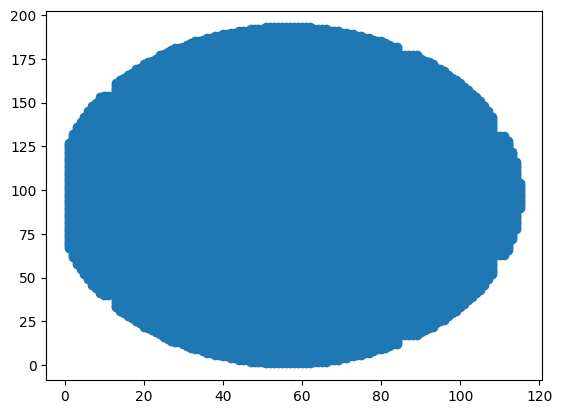

In [24]:
# 'wafer_1_x_y' 데이터프레임에서 'x'와 'y' 컬럼의 값을 기반으로 산점도 그리기
plt.scatter(x=wafer_1_x_y["x"], y=wafer_1_x_y["y"])
plt.show()

예상대로 원이 그려졌습니다. 즉 위 데이터프레임에서 x와 y의 값은 이미지에서의 좌표를 표현하는 값이 맞았습니다. 

1번 웨이퍼의 정보를 따로 추출하여 `wafer_1`데이터프레임으로 옮겨보겠습니다.



In [25]:
wafer_1 = df[df["wafer"] == 1]
wafer_1

,wafer,x,y,ring,spot,trend,twospots,crescent
0,1,1,67,0.033203,0.000065,0.312295,0.039043,0.007720
1,1,1,68,0.032817,-0.000005,0.288025,0.040563,0.002636
2,1,1,69,0.033321,0.000025,0.261521,0.041602,-0.000592
3,1,1,70,0.032707,-0.000014,0.290741,0.040822,0.008510
4,1,1,71,0.032220,-0.000049,0.256578,0.042526,0.009654
...,...,...,...,...,...,...,...,...
17504,1,115,100,0.033149,0.000074,0.117093,0.044363,0.425392
17505,1,115,101,0.033553,0.000010,0.191086,0.044552,0.424840
17506,1,115,102,0.032644,0.000017,0.161394,0.044907,0.431352
17507,1,115,103,0.032956,-0.000150,0.168589,0.046049,0.422307


그렇다면, 데이터프레임의 행은 하나의 픽셀에서 각각의 결함이 얼마만큼의 강도를 갖는지를 내포한 구조임을 알 수 있습니다.

wafer의 열은 웨이퍼의 번호를 의미하는 셈이었던 것입니다.

웨이퍼를 시각화하여 이미지로 표현해보면 더 많은 단서를 얻을 수 있습니다.

### 2.5 데이터 시각화

웨이퍼 하나 당 5가지 결함 정보를 모두 갖고 있으므로, 하나의 웨이퍼에 대해 4장의 이미지를 생성할 수 있습니다.

우리는 이 5가지 이미지를 바탕으로, 각 이미지가 어느 분류에 속하는지 예측하는 분류 문제를 풀어보도록 하겠습니다.  

우선 각 결함을 시각화할 함수를 선언하겠습니다.

### [TODO] 아래 시각화 함수의 빈칸을 완성해주세요. 헷갈리는 부분은 주석을 참조하여 만들어봅시다.

In [26]:
def create_image(df, wafer_id, pattern):
    """특정 wafer 및 패턴에 대한 이미지를 생성하는 함수"""
    
    # 주어진 wafer_id에 해당하는 데이터만 선택
    wafer_data = df[df["wafer"] == wafer_id]
    # 이미지의 크기를 설정하고, 초기값은 모두 0으로 채워진 배열 생성
    image = np.zeros((193, 115))  # y, x 최대값을 기준으로 이미지 크기 설정
    # wafer_data의 각 행에 대해 반복하며 이미지 데이터 업데이트
    for index, row in wafer_data.iterrows():
        # 'x', 'y' 위치 및 패턴 값 추출
        x, y, value = int(row["x"] - 1), int(row["y"] - 1), row[pattern]
        # 이미지에 패턴 값 설정
        image[y, x] = value

    return image

> 예시코드
```py
def create_image(df, wafer_id, pattern):
    """특정 wafer 및 패턴에 대한 이미지를 생성하는 함수"""
    
    # 주어진 wafer_id에 해당하는 데이터만 선택
    wafer_data = df[df["wafer"] == wafer_id]
    # 이미지의 크기를 설정하고, 초기값은 모두 0으로 채워진 배열 생성
    image = np.zeros((193, 115))  # y, x 최대값을 기준으로 이미지 크기 설정
    # wafer_data의 각 행에 대해 반복하며 이미지 데이터 업데이트
    for index, row in wafer_data.iterrows():
        # 'x', 'y' 위치 및 패턴 값 추출
        x, y, value = int(row["x"] - 1), int(row["y"] - 1), row[pattern]
        # 이미지에 패턴 값 설정
        image[y, x] = value

    return image
```

위의 함수는 다음과 같은 구조로 구성됩니다.

- 입력

    - `df`: 원본 데이터프레임.
    - `wafer_id`: 이미지를 생성하고자 하는 wafer의 ID.
    - `pattern`: 고려하고자 하는 패턴의 컬럼 이름.
- 동작

    - 주어진 `wafer_id`에 해당하는 데이터만 `wafer_data`에 저장합니다.
    - `np.zeros`를 사용하여 (193, 115) 크기의 2차원 배열을 생성합니다. 이 배열은 이미지 데이터를 담을 것이며, 초기에는 모든 값이 0입니다.
    - `wafer_data`의 각 행에 대해 반복하며, 해당 행의 'x'와 'y' 위치 값을 추출합니다. 이 위치에 해당하는 이미지 데이터의 값을 패턴 값으로 설정합니다.
- 출력

    - 생성된 2차원 이미지 데이터.

선언된 함수를 바탕으로 이미지를 시각화해보겠습니다.

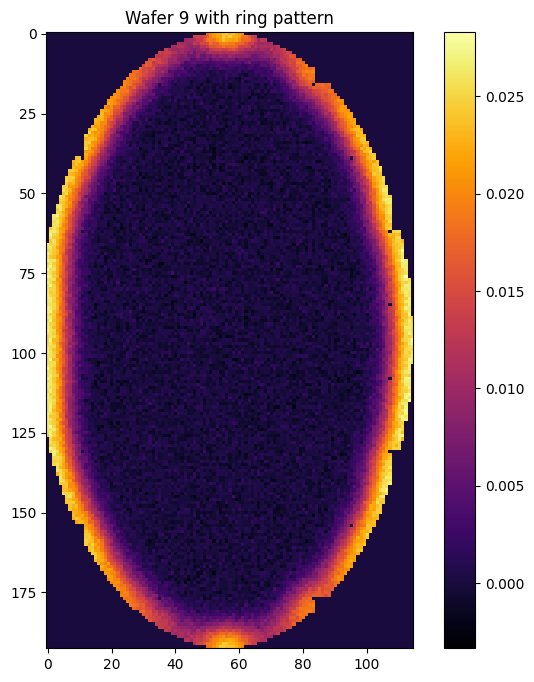

In [27]:
# 첫 번째 wafer의 ring 패턴에 대한 이미지 생성 및 시각화

# wafer ID와 패턴 설정
wafer_id = 9
pattern = "ring"#ring spot trend twospots crescent

# 위에서 정의한 함수를 사용해 이미지 데이터 생성
image = create_image(df, wafer_id, pattern)

# 이미지 데이터 시각화
plt.figure(figsize=(8, 8))       # 그림의 크기 설정
plt.imshow(image, cmap='inferno')  # 이미지 데이터를 화면에 표시, 'inferno' 색상 맵 사용
plt.colorbar()                   # 색상 막대 표시
plt.title(f"Wafer {wafer_id} with {pattern} pattern")  # 그림 제목 설정
plt.show()                       # 그림 표시

9번 웨이퍼에 대한 Spot 결함 이미지가 위와 같이 그려집니다. 말 그대로 웨이퍼의 특정 부분에 반점이 표현됩니다.

위 wafer_id와 패턴을 바꾸어가며 다양한 이미지를 시각화해보세요.

### [TODO] 위 wafer_id와 패턴을 바꾸어가며 다양한 이미지를 시각화해보세요.

> 예시코드
```py
# wafer ID와 패턴 설정
wafer_id = 15
pattern = "ring"

# 위에서 정의한 함수를 사용해 이미지 데이터 생성
image = create_image(df, wafer_id, pattern)

# 이미지 데이터 시각화
plt.figure(figsize=(8, 8))       # 그림의 크기 설정
plt.imshow(image, cmap='inferno')  # 이미지 데이터를 화면에 표시, 'inferno' 색상 맵 사용
plt.colorbar()                   # 색상 막대 표시
plt.title(f"Wafer {wafer_id} with {pattern} pattern")  # 그림 제목 설정
plt.show()       
```

## 3. 이미지 변환

위에서 파악한 데이터프레임의 구조와 정보를 바탕으로 데이터셋을 만들어보도록 하겠습니다.

5가지 결함 정보가 정답인 상황에서, 각 이미지를 바탕으로 정보를 추론하여 결함 유형을 분류하는 모델을 위해 데이터셋을 만들겠습니다.

우선 딥러닝 연산과정에서 숫자가 아닌 데이터는 계산될 수 없으므로 이미지에 대한 레이블을 정수로 바꿔보겠습니다.

데이터프레임의 열 이름정보를 리스트로 변환하여 `defect_features`에 저장합니다.

In [28]:
defect_features = df.columns[3:].tolist()
defect_features

['ring', 'spot', 'trend', 'twospots', 'crescent']

### 3.1 이미지 및 레이블 생성

이어 데이터프레임을 바탕으로 웨이퍼 이미지와 레이블을 생성하는 함수를 선언합니다.

함수를 아래와 같은 구조로 설계하겠습니다.

- 입력

    - `df`: 원본 데이터프레임.
    - `wafer_num`: 이미지를 생성하고자 하는 wafer의 번호.

- 동작

    - 주어진 `wafer_num`에 해당하는 데이터만 `wafer_data`에 저장합니다.

    - `defect_features`에 정의된 각 결함 유형에 대해 반복하여 이미지 데이터를 생성합니다.

    - 생성된 이미지 데이터와 레이블 정보를 각각 `images`와 `labels` 리스트에 추가합니다.

- 출력

    - 생성된 이미지 데이터의 리스트와 그에 해당하는 레이블 정보의 리스트

In [29]:
def create_images_from_dataframe(csv, wafer_num):
    wafer_data = csv[csv['wafer'] == wafer_num]
    
    images = []
    labels = []
    
    for idx, defect in enumerate(defect_features):
        defect_values = wafer_data.pivot(index='x', columns='y', values=defect).fillna(0).values
        image = np.copy(defect_values)
        images.append(image)
        labels.append(idx)

    return images, labels

위 함수의 구조대로, 데이터프레임 내의 모든 wafer에 대해 이미지와 레이블 데이터를 생성하고, 그 결과를 새로운 데이터프레임으로 변환하는 과정을 수행합니다.

시간이 조금 소요됩니다. 기다리며 잠시 스트레칭을 해 볼까요?

### [TODO] 위의 함수를 데이터프레임에 적용하여, 이미지와 레이블들을 리스트에 담아 새로운 데이터프레임으로 변환해주세요.
헷갈리는 부분은 주석을 참고하여 진행해주세요.

In [30]:
# 모든 이미지와 레이블을 저장할 리스트 초기화
all_images = []
all_labels = []

# tqdm을 사용하여 진행 상황 표시와 함께 데이터프레임 내의 모든 wafer에 대해 반복
for wafer_num in tqdm(df['wafer'].unique()):
    # 각 wafer에 대해 이미지와 레이블 데이터 생성
    images, labels = create_images_from_dataframe(df, wafer_num)
    # 생성된 이미지와 레이블 데이터를 전체 리스트에 추가
    all_images.extend(images)
    all_labels.extend(labels)

# 이미지와 레이블 데이터를 데이터프레임으로 변환
image_df = pd.DataFrame({'image': all_images, 'label': all_labels})

100%|██████████| 200/200 [00:03<00:00, 58.58it/s]


> 예시코드
```py
# 모든 이미지와 레이블을 저장할 리스트 초기화
all_images = []
all_labels = []

# tqdm을 사용하여 진행 상황 표시와 함께 데이터프레임 내의 모든 wafer에 대해 반복
for wafer_num in tqdm(df['wafer'].unique()):
    # 각 wafer에 대해 이미지와 레이블 데이터 생성
    images, labels = create_images_from_dataframe(df, wafer_num)
    # 생성된 이미지와 레이블 데이터를 전체 리스트에 추가
    all_images.extend(images)
    all_labels.extend(labels)

# 이미지와 레이블 데이터를 데이터프레임으로 변환
image_df = pd.DataFrame({'image': all_images, 'label': all_labels})
```

결과가 저장된 `image_df`데이터프레임을 한 번 살펴보겠습니다.

In [31]:
image_df.head()

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4


각 웨이퍼에 대하여 5가지 클래스에 대한 이미지가 모두 생성되어야 합니다. 

웨이퍼가 총 200개 존재하므로, 이에 대하여 200 * 5 = 1000개의 이미지가 생성되어야 합니다.

In [32]:
image_df.shape

(1000, 2)

### 3.2 이미지 시각화

생성된 이미지를 시각화해보겠습니다. 

아래 코드의 `labels` 변수 값을 바꾸어가며 특정 레이블 별로 이미지가 잘 생성되었는지 확인해봅시다.

twospots


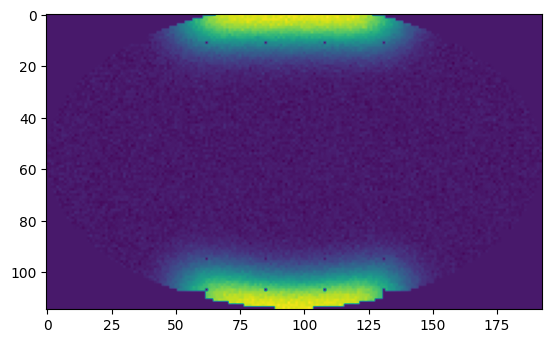

twospots


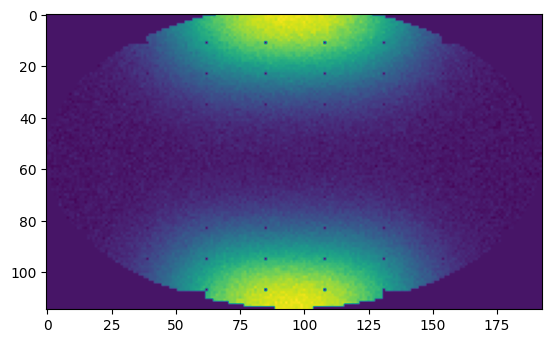

twospots


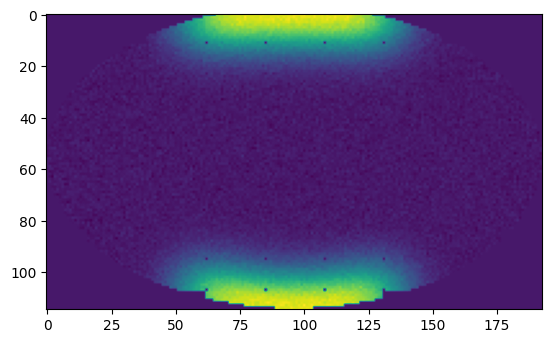

twospots


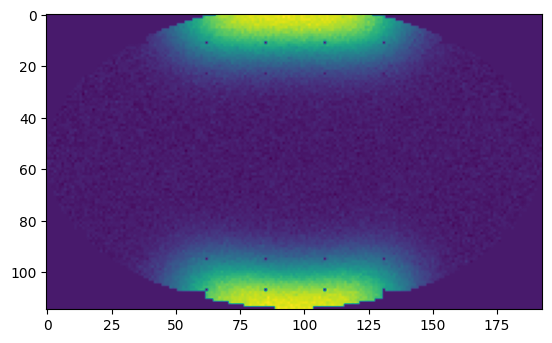

In [33]:
# labels 값을 3으로 설정
labels = 3

# 처음 20개의 이미지 중 레이블이 3인 이미지만 시각화
for i in range(20):
    # 레이블이 3인 경우만 처리
    if all_labels[i] == labels:
        # 해당 레이블에 매치되는 결함 유형 출력
        print(defect_features[labels])
        _ = all_images[i]
        # 해당 이미지 시각화
        plt.imshow(_)
        plt.show()

### [TODO] label 변수 값을 바꿔 추가적인 이미지를 시각화해보고, 그 특징을 파악해봅시다.

> 예시코드
```py
# labels 값을 3으로 설정
labels = 3

# 처음 20개의 이미지 중 레이블이 3인 이미지만 시각화
for i in range(20):
    # 레이블이 3인 경우만 처리
    if all_labels[i] == labels:
        # 해당 레이블에 매치되는 결함 유형 출력
        print(defect_features[labels])
        _ = all_images[i]
        # 해당 이미지 시각화
        plt.imshow(_)
        plt.show()
```

### 3.3 이미지의 크기 확인

딥러닝 모델에 데이터를 입력하기 위해선 가로와 세로의 크기가 일정해야합니다.

그렇지 않다면, 차원이 맞지 않는 오류로 인해 학습이 불가능합니다.

그러한 이유로, 이미지 데이터를 모델에 넣기 전 사이즈를 일괄 조정하는 Resizing 과정을 거칩니다.

일반적으로 원본 이미지보다 작은 크기로 이미지를 resizing하며, 가로 세로 픽셀의 수도 합리적으로 정해야 합니다.

그렇기에 우리가 갖고있는 전체 이미지에 대한 가로와 크기 분포를 확인해보도록 하겠습니다.

데이터프레임에 있는 모든 이미지 값들의 가로와 세로 크기를 히스토그램으로 표현해보겠습니다.

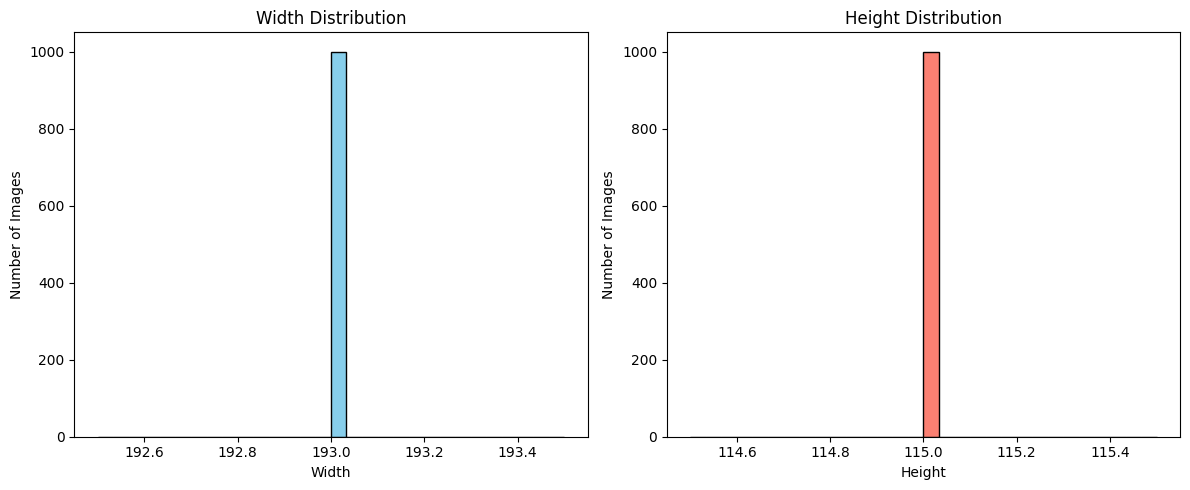

In [34]:
# image_df 데이터프레임에서 각 이미지의 너비와 높이 추출
widths = [image.shape[1] for image in image_df['image']]
heights = [image.shape[0] for image in image_df['image']]

# 분포를 표시하기 위한 그래프 설정
plt.figure(figsize=(12, 5))

# 너비 분포
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Number of Images')

# 레이아웃 조정
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

다행이도 모든 데이터에 대해 폭은 193, 높이는 115로 일정합니다.

초기 데이터프레임에서 x의 최댓값이 115이고, y열의 최댓값이 193이었으나 연산 도중 두 값의 위치가 바뀌었습니다.

Wafer 데이터의 경우 원반의 형태이므로 이 부분은 따로 처리하지않고 넘어가도록 하겠습니다.

Resizing 과정에서 가로와 세로 값은 115이하로 설정하겠습니다.

그 이유는 원본 이미지보다 크게 확장하여 모델에 입력할 경우, 데이터를 늘리는 과정에서 중요한 정보가 손실될 수 있기 때문입니다.

### 3.4 이미지의 값 확인

대부분의 이미지는 [0, 255]구간에서 표현되지만, 모델에 투입되기 전에는 [0, 1]구간으로 변환됩니다. 

그 이유는 값이 클 수록 연산 속도가 오래 걸리며, 모델의 학습 과정에서 손실 값이 잘 수렴하지 못하기 때문입니다.

이 과정을 흔히 Standardization 혹은 Min-max scaling이라 불립니다.

이미지의 전체 값 중, 가장 큰 값과 가장 작은 값 사이에서 스케일링하기 때문입니다.

우선 모든 이미지 중 최댓값과 최솟값을 추출해보겠습니다.

np의 `min`과 `max` 메서드를 통해 확인이 가능합니다.

In [35]:
print(np.min(all_images), np.max(all_images))

-1.06404292550426 3.12471674844968


최댓값과 최솟값이 [0, 1] 구간에서 표현되지 않으므로 스케일링이 필요해보입니다.

Resizing과 Scaling은 데이터셋 생성 과정 중에 같이 수행하도록 하겠습니다.

## 4. 데이터셋 생성

데이터셋을 만들어보도록 하겠습니다.

데이터셋 클래스는 Pytorch의 Dataset 클래스를 상속받아 만들 수 있습니다. 

데이터셋 클래스는 다음 세 메서드를 포함합니다.

- `__init__`: 생성자에서는 데이터프레임과 이미지 변환(transform)을 인자로 받아 초기화합니다. 이미지 변환은 옵션으로, 주어지지 않을 경우 None으로 설정됩니다.

- `__len__`: 이 메서드는 데이터셋의 전체 길이, 즉 데이터프레임에 있는 데이터의 수를 반환합니다.

- `__getitem__`: 이 메서드는 주어진 인덱스 idx에 해당하는 이미지와 레이블을 반환합니다. 또한 transform이 지정된 경우 해당 변환을 이미지에 적용합니다.

앞서 말한 두 가지 전처리 과정인 Resizing과 Min-max scaling은 `__getitem__`메서드가 호출될 때, 이미지에 적용될 수 있도록 구성해야 합니다.

해당 기능들은 transform attribute에 저장해놓겠습니다.

In [36]:
# WaferDataset 정의 - torch의 Dataset 클래스를 상속받음
class WaferDataset(Dataset):
    # 생성자
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe  # 데이터를 저장하는 데이터프레임
        self.transform = transform  # 이미지 변환을 위한 transform

    # 데이터셋의 전체 길이 반환
    def __len__(self):
        return len(self.dataframe)

    # idx에 해당하는 이미지와 레이블 반환
    def __getitem__(self, idx):
        # dataframe에서 idx에 해당하는 이미지와 레이블 추출
        image = torch.tensor(self.dataframe.iloc[idx, 0]).float()
        label = torch.tensor(self.dataframe.iloc[idx, 1]).long()
        
        # transform이 지정된 경우 이미지에 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

클래스 선언이 완료되었다면, 앞서 말한 두 가지 전처리 과정을 코드로 구현하겠습니다.  

Pytorch에는 다양한 API가 존재합니다. 그 중 `torchvision` API는 이미지 처리와 관련된 다양한 툴을 제공합니다.  

그 중 하나가 바로 `transforms`입니다. `transforms`는 PyTorch의 `torchvision` 라이브러리 내부에 있는 모듈로, 주로 이미지 데이터에 대한 다양한 전처리 및 변환 작업을 지원합니다. 

이미지 데이터를 딥러닝 모델에 입력하기 전에 적절한 형태나 크기로 바꾸거나, 데이터를 증강하는 등 기능이 주로 사용됩니다.

Transforms에 포함될 기능 중 Min-max scaling의 경우 별도로 함수를 만들도록 하겠습니다.

그 이유는 이번 데이터셋의 값이 일반적인 이미지와 값의 범위가 다르기 때문입니다. 커스터마이징을 위해 함수를 아래와 같이 선언합니다.

In [37]:
test = WaferDataset(df)
test.transform

In [38]:
len(test)

3501800

### [TODO] Min-max 스케일링 함수를 완성해봅시다.

Min - max 스케일링은 이미지 내 가장 큰 값을 1로, 가장 작은 값을 0으로 기준을 잡고 나머지 픽셀들을 [0, 1]사이에 표현하는 전처리 과정입니다.

In [39]:
# Min-Max 스케일링 함수 정의
def minmax_scaling(img):
    # 이미지의 최소값과 최대값 계산
    min_val = torch.min(img)
    max_val = torch.max(img)
    
    # 최대값과 최소값의 차이가 매우 작은 경우 (0 방지)
    if max_val - min_val < 1e-9:
        return img
    # Min-Max 스케일링 적용
    return (img - min_val) / (max_val - min_val)

> 예시코드
```py
# Min-Max 스케일링 함수 정의
def minmax_scaling(img):
    # 이미지의 최소값과 최대값 계산
    min_val = torch.min(img)
    max_val = torch.max(img)
    
    # 최대값과 최소값의 차이가 매우 작은 경우 (0 방지)
    if max_val - min_val < 1e-9:
        return img
    # Min-Max 스케일링 적용
    return (img - min_val) / (max_val - min_val)
```

함수가 선언되었다면, 이를 비롯한 다양한 기능을 `Compose`로 감싸 데이터셋 클래스에 전달할 준비를 마치겠습니다.

In [40]:
# 이미지 변환을 위한 Compose 정의
resize_transform = transforms.Compose([
    transforms.Lambda(minmax_scaling),  # Min-Max 스케일링 적용
    transforms.ToPILImage(),           # 이미지를 PIL 형식으로 변경
    transforms.Resize((96, 96)),       # 이미지 크기를 96x96으로 조정
    transforms.ToTensor(),             # PIL 이미지를 Tensor로 변환
])

데이터셋 클래스와 Compose를 바탕으로 데이터셋 인스턴스를 생성하도록 하겠습니다.

In [41]:
dataset = WaferDataset(image_df, transform=resize_transform)

데이터셋이 제대로 만들어졌는지 확인하기위해 총 데이터의 수를 `__len__()`메서드로 확인해보겠습니다.

In [42]:
dataset.__len__()

1000

`__getitem__`메서드를 통해 데이터를 꺼내 확인도 해보겠습니다.

In [43]:
x, y = dataset.__getitem__(1)
print(x.shape)
print(y)

torch.Size([1, 96, 96])
tensor(1)


다만 이상한 점은, 이미지가 흑백 데이터임에도 불구하고, 3차원의 구조로 표현되었습니다.

이는 Compose 중 `transforms.ToPILImage()`메서드로 인해 발생한 현상입니다.  

대부분의 CNN 모델들은 Convolution 필터를 통해 이미지 연산을 수행하며, 이 필터는 반드시 3차원 형태의 데이터만 입력받을 수 있습니다.

이를 위해 자동적으로 이미지를 3차원으로 변환하는 기능이 포함된 것입니다.

Torch의 `squeeze` 기능을 활용하면, 특정 차원을 제거할 수 있습니다.

In [44]:
# x 텐서에서 차원의 크기가 1인 첫 번째 차원을 제거
x_squeezed = x.squeeze(0)

# x_squeezed의 형태를 확인
x_squeezed.shape

torch.Size([96, 96])

이미지의 가로 세로 Resizing이 성공적으로 수행된 것을 확인했습니다.

이번에는 Min-max scaling이 제대로 수행되었는지, 행렬의 최댓값과 최솟값을 확인해보겠습니다.

다만, Dataset 내부의 데이터들은 `transforms.ToTensor()` 전처리를 통과하며 Torch의 tensor 형태로 저장이 된 상황입니다.

이 경우 numpy의 `min` `max`메서드가 아닌 Torch의 `min` `max`메서드를 사용해야 합니다.

In [48]:
x

tensor([[[0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         ...,
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627]]])

### [TODO] x_squeezed의 최솟값과 최댓값을 출력해봅시다.

In [45]:
print(torch.min(x_squeezed), torch.max(x_squeezed))

tensor(0.0314) tensor(0.9686)


> 예시코드
```
print(torch.min(x_squeezed), torch.max(x_squeezed))
```

정상적으로 스케일링도 적용되었습니다. 

이번에는 데이터셋의 특정 인덱스를 입력하면 이미지와 레이블을 시각화하는 함수를 만들어보겠습니다.

주의해야할 점은, Torch tensor을 바로 시각화할 수 없으므로 이를 다시 Numpy ndarray로 변환하는 과정이 필요합니다.

### [TODO] 아래 시각화 함수를 완성시켜봅시다.

헷갈리는 부분은 주석을 참조하여 완성해주세요.

In [46]:
def show_wafermap(dataset, idx):
    # 주어진 인덱스에 해당하는 이미지와 레이블을 가져옴
    image, label = dataset[idx]
    
    # 이미지에서 불필요한 차원 제거 및 numpy 배열로 변환
    image = image.squeeze(0).numpy()
    
    # 레이블을 numpy 배열로 변환
    label = label.numpy()
    
    # 이미지 시각화 설정
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='inferno')  # 이미지 표시
    plt.title(f"Class Label: {label}")  # 이미지 위에 레이블로 제목 설정
    plt.axis('off')  # 축 정보 숨기기
    plt.colorbar(label='Defect Intensity')  # 컬러바 표시 및 라벨 설정
    plt.show()  # 이미지 표시

> 예시코드
```py
def show_wafermap(dataset, idx):
    # 주어진 인덱스에 해당하는 이미지와 레이블을 가져옴
    image, label = dataset[idx]
    
    # 이미지에서 불필요한 차원 제거 및 numpy 배열로 변환
    image = image.squeeze(0).numpy()
    
    # 레이블을 numpy 배열로 변환
    label = label.numpy()
    
    # 이미지 시각화 설정
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='inferno')  # 이미지 표시
    plt.title(f"Class Label: {label}")  # 이미지 위에 레이블로 제목 설정
    plt.axis('off')  # 축 정보 숨기기
    plt.colorbar(label='Defect Intensity')  # 컬러바 표시 및 라벨 설정
    plt.show()  # 이미지 표시
```

이미지를 시각화해봅시다.

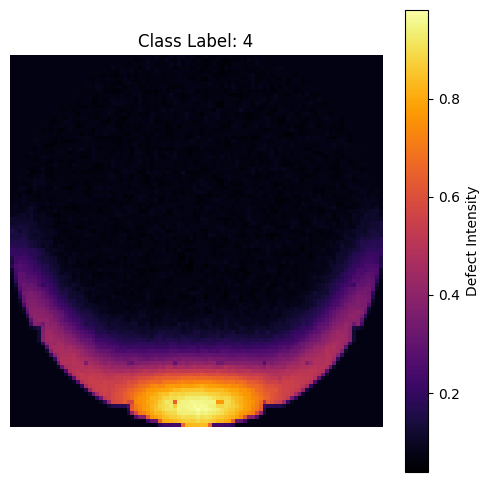

In [47]:
# 이미지를 시각화합니다.
show_wafermap(dataset, 9)

훌륭합니다. 이로써 데이터셋이 완성되었습니다.

다만 아쉬운 점은 데이터셋을 그 자체로 저장할 수 없다는 것입니다.

그러므로 우리는 이미지와 레이블이 저장된 리스트(`all_images`, `all_labels`)들을 저장하여, 이를 다시 불러오는 형태로 진행해보겠습니다.

파이썬의 `pickle`라이브러리를 활용하여 두 리스트를 저장하겠습니다.

In [49]:
import pickle

# pickle을 사용하여 all_labels와 all_images 저장
images_save_path = 'images.pkl'
labels_save_path = 'labels.pkl'

# 이미지 리스트를 'images.pkl' 파일로 저장
with open(images_save_path, 'wb') as f:
    pickle.dump(all_images, f)

# 레이블 리스트를 'labels.pkl' 파일로 저장
with open(labels_save_path, 'wb') as f:
    pickle.dump(all_labels, f)

images_save_path, labels_save_path

('images.pkl', 'labels.pkl')

두 데이터는 현재 여러분들이 사용중인 디렉토리에 바로 저장되니, 다음에도 아래 코드를 이용하여 편하게 불러올 수 있습니다.

또한 아래 두 코드셀을 실행하면, 이번 시간에 만들었던 데이터셋을 간단하게 생성할 수 있습니다.

In [50]:
import pickle
import numpy as np
import pandas as pd

# 'images.pkl'와 'labels.pkl' 파일에서 데이터를 로드하기 위해 pickle 사용
with open("images.pkl", "rb") as f:
    all_images_loaded = pickle.load(f)

with open("labels.pkl", "rb") as f:
    all_labels_loaded = pickle.load(f)

# 로드된 이미지와 레이블을 데이터프레임으로 변환
image_df_loaded = pd.DataFrame({'image': all_images_loaded, 'label': all_labels_loaded})

In [51]:
# 결함 특징 목록 정의
defect_features = ['ring', 'spot', 'trend', 'twospots', 'crescent']

import torch
from torch.utils.data import Dataset

# 웨이퍼 데이터셋 클래스 정의
class WaferDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    # 데이터셋의 전체 길이 반환
    def __len__(self):
        return len(self.dataframe)

    # 특정 인덱스의 데이터 반환
    def __getitem__(self, idx):
        image = torch.tensor(self.dataframe.iloc[idx, 0]).float()
        label = torch.tensor(self.dataframe.iloc[idx, 1]).long()
        
        # 변형(transform)이 정의된 경우 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 이미지 데이터의 Min-Max 정규화 함수
def minmax_scaling(img):
    min_val = torch.min(img)
    max_val = torch.max(img)
    if max_val - min_val < 1e-9:  # 작은 값 추가하여 0 방지
        return img
    return (img - min_val) / (max_val - min_val)

# 이미지 변형(리사이징 및 정규화) 파이프라인 정의
resize_transform = transforms.Compose([
    transforms.Lambda(minmax_scaling),
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),  # 원하는 크기로 변경
    transforms.ToTensor(),
])

# 데이터셋 객체 생성
dataset = WaferDataset(image_df_loaded, transform=resize_transform)

이로써 데이터를 전처리하고, 데이터셋을 만드는 과정을 경험해보았습니다. 다음에는 이 내용을 바탕으로 모델을 간단하게 만들어보도록 하겠습니다.

수고하셨습니다.